# 프로그램 기본 설정

In [1039]:
# import

%matplotlib inline

from IPython.display import display

import re
import math
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import random

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy import stats
from scipy.stats import ttest_1samp, ttest_ind


#pandas에서 DataFrame을 요약해서 표시하지 않도록 설정
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# head로 표시할 데이터 갯수 
print_row_count = 3



# 줄 구분 표시 출력 
def print_line() :
  print ("\n------------------------------------------------")
def print_line_m() :
  print ("\n-----------------------")
def print_line_s() :
  print ("\n----------")


colors = sns.color_palette('pastel')[0:5]

## 함수 정의

In [1046]:
# 독립집합인 a ,b 에 대한 T-test 수행 결과를 print 하고 P-value를 반환
# 에러시 np.nan 반환
'''
  prm_alternative : 
    'less' : 대안가설이 = 왼쪽의 평균이  오른쪽 보다 작다 인 경우
    'greater' 
    'two-sided' : 대안가설이 = 왼쪽 오른쪽의 평균이 다르다 인 경우  
'''
def t_test ( a, b , prm_alternative ) :
  ret_value = np.nan

  # 정규성 검사 
  # : T-검정은 데이터의 정규본포를 가정으로 하는 검증법이다.
  # a0_pvalue 와 a1_pvalue 모두 > 0.05 보다 큰지 여부 확인 하여 
  # 둘 다 정규성을 만족하지 않는 경우 진행 중단.
  # shapiro test p>0.05이면 정규성이 보장된다. 
  sha_a0, a0_pvalue = stats.shapiro(a)
  sha_a1, a1_pvalue = stats.shapiro(b)
  if ( (a0_pvalue <= 0.05) | (a1_pvalue <= 0.05) ) :
    print ("(todo) 에러 발생")
    return ret_value

  # 분산의 동질성 검정
  # scipy.ttest_ind ( ) 를 사용하기 위해서는 분산 동질성 여부를 알고 있어야 한다.
  flg_분산동질여부 = False
  l, p = stats.levene(a,b)
  if p > 0.05 : # 0.05보다 큰 경우 분산은 동질성을 가지고 있다고 할 수 있음
    flg_분산동질여부 = True

  # T 검정 수행
  # alternative='less' : 대안가설이 = 왼쪽의 평균이  오른쪽 보다 작다 인 경우
  # greater
  # alternative='two-sided' : 대안가설이 = 왼쪽 오른쪽의 평균이 다르다 인 경우  
  t, p = stats.ttest_ind(a, b , equal_var= flg_분산동질여부 , alternative=prm_alternative )


  # 결과출력
  # p < 0.05 인 귀무가설 기각
  rslt_맞는가설 = '귀무가설'
  if ( p < 0.05 ) :
      rslt_맞는가설 = '대립가설'
  print ( f"{rslt_맞는가설}이 맞음" )

  ret_value = p 
  
  return ret_value

## 기초 데이터 로딩

In [1074]:
#  정제된 data loading 

# Data 로드
df_tmp = pd.read_csv( "https://raw.githubusercontent.com/LamuneGitHub/AI15_Prj_01/main/vgames2_after_cleaning_01.csv" , sep=","  , header=0  ) 
df_target = df_tmp


In [1078]:
# 데이터 type 재 지정
df_target.Platform = df_target.Platform.astype('category')
# (TODO) 연도 컬럼의 카테고리 값의 순서 지정
#df_target.Year = df_target.Year.astype('category')
df_target.Genre = df_target.Genre.astype('category')
df_target.Type = df_target.Type.astype('category')

df_target['sum_Sales'] = df_target.NA_Sales + df_target.EU_Sales + df_target.JP_Sales + df_target.Other_Sales


df_target.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16241 entries, 0 to 16240
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Platform     16241 non-null  category
 1   Year         16241 non-null  int64   
 2   Genre        16241 non-null  category
 3   NA_Sales     16241 non-null  int64   
 4   EU_Sales     16241 non-null  int64   
 5   JP_Sales     16241 non-null  int64   
 6   Other_Sales  16241 non-null  int64   
 7   Type         16241 non-null  category
 8   sum_Sales    16241 non-null  int64   
dtypes: category(3), int64(6)
memory usage: 810.8 KB


# # 분석 작업

## 1. 최종 분석 목표 
## **# 다음 분기에 어떤 게임을 설계해야 하는가 ?**

### 1.1 목표 상세 정의
    ## 최종 목표 요청사항 상세 정의 
    = 1 단계 
        * 어떤 장르를 개발해야 하는가?
        * 어떤 플렛폼용으로 개발해야 하는가?
        * 어떤 지역( 언어지원 , 주요 마켓팅 역량 집중 )을 주요 타겟으로 잡아야 하는가?

    = 2 단계
        목표 -> 각 장르별로 매출이 높을 확률 ? 베이지안 
            A : hit 게임
            B : 장르(각)

            P(A|B) = P(B|A) * P(A) / P(B)

        목표 -> 각 플렛폼 별로 매출이 높을 확률  ? 베이지안
            A : hit 게임
            B : 플렛폼(각)

            P(A|B) = P(B|A) * P(A) / P(B)

        목표 -> 각 지역별로 언어지원,집중 마켓팅을 했을때 매출이 높을 확률  ? 베이지안
            A : hit 게임
            B : 지역(각)

            P(A|B) = P(B|A) * P(A) / P(B)


    = 3 최종 선택은 ?
        * 최고로 높은 확률의 조합이 정답이 아니다.
            개발팀의 자원에 따라 취사 선택 및 전략의 선택이 필요 하다.
            -> 각각의 데이터를 모두 전달 후 상황에 맞게 전략을 선택할 수 있게 해주자

            ex) 블루오션을 , 레드오션
        
        * 분석 결과의 해석은 관점에 따라서 달라질 수 있다.
            - a장르의  hit 게임의 확률이 높다는 것은
                - a장르를 좋아하는 사람이 많다는 의미
                - a장르에 높은 개발력 , 혹은 충성도를 가지고 있는 경쟁사가 있다는 의미
                    ( 반대의 경우 높은 개발력을 가진 회사가 적다 혹은 신규 시장이다. 로 해셕할 수도 있다. )
            - 개발 전략을 수립하는 과정에서 계속 재 해석이 필요할 것이다. 

                -> 요청 사항이 ... 최신 트렌드 , 성공할 확률이 높은 선택지를 찾아줘로 느껴졌기 때문에 첨부한 첨언임

        * 95%의 신뢰도를 가지도록 분석하였지만 , 5%의 확률은 일상에서 매우 흔하게 자주 발생한다.
            TRPG 게임을 하다보면 20면체 주사위를 굴릴때 크리티컬이 나와서 끝났다고 생각하던 때에 역전승을 하거나
                다 이겼다고 생각될 때 펌블이 나와서 망하는 경우가 아주 흔하게 발생한다는 것을 기억해라

        * 개발팀의 역량 과 능력, 가지고 있는 자원에 대한 파악이 핵심이고 성공으로 향하는 올바른 시작이다.
        

### 1.2 필요 정보, 데이터
    * 과거의 데이터는 현재의 상활을 파악하는데 의미있는 정보가 아닐 수 있다.
        -> 최신의 데이터를 사용 -> 5년 ? 10년?
    
    * 구해야(필요한) 하는 확률 값 
        - P ( 장르(각각) | hit 게임 )
        - P ( hit 게임 )
        _ P ( 장르(각각) )
        
        - P ( 플랫폼(각각) | hit 게임 )
        - P ( 플랫폼(각각) )
        
        - P ( 지역(각각) | hit 게임 )
        - P ( 지역(각각) )

    * hit 게임의 정의
        (!문제점) 출고량이 높은 게임의 기준이 모호함

        - 출고량이 높은 게임에 label 표시 -> 데이터가 너무 많아서 불가능
        - 특정값 이상 -> 연도별 특성 고려하는 것이 올바를 것 같음
            -> 연도별 특성을 고려하지 않는다면 특정값은 어떻게 정하는게 좋을까?
        - 매출량 상위 25% 를 출고량이 높은것 ?
        - 매출량 정규화 후 상위 5% ? 10% ?
        - kmeans로 데이터 그룹핑 후 구분
            - 매출을 기준으로 
                하하 ~ 상상 9 단계로 클러스터링 후 분류해 볼까?
            
            * 분석 데이터는 부트 스트렙을 해야 하는가?
                - 부트스트랩의 평균값은 모수의 평균값과 같다
                - 모수의 연도별, 지역별 매출 평규값을 구할 수 있다.
                -> 분석데이터는 부트스트렙한 데이터를 사용한다.

            *  적당한 그룹수를 찾기
                -> (TODO) elbow 메소드 이용해서 값 정하기 시도 해보자
        -> kmeans로 클러스러팅 진행하여 
            최 상위 매출 그룹을 hit-게임으로 정의
        

### 1.3 분석 진행

* 사용할 데이터의 연도 정하기  

    -> 최근 10년의 데이터를 사용

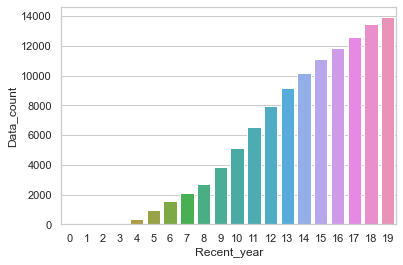

In [1082]:
#(v) 사용할 데이터의 연도 정하기
df = df_target

max_year = df.Year.max()
max_year

list_data_count = [ len(df[df.Year >= max_year - i ]) for i in range ( 20 ) ] 
list_data_count

recent_year =  list( range(len(list_data_count)) )  
recent_year

df_ploat = pd.DataFrame (
    {
        "Recent_year" : recent_year ,
        "Data_count" : list_data_count
    }
)

sns.barplot ( data = df_ploat  ,x ='Recent_year' ,  y = 'Data_count')

#(v) 분석에 사용하는 data는 최근 10년으로 정함
recent_year_boundary = 10

In [1084]:
#(TODO) 갑자기 동작 안함
# sns.countplot ( data = df , x='sum_Sales')

* hit 게임 기준 정하기

    -> K-means 분류.    
    -> 매출 구분  8 단계중 상위 2단계

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 4051 to 12597
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype   
---  ------       --------------    -----   
 0   Platform     1000000 non-null  category
 1   Year         1000000 non-null  int64   
 2   Genre        1000000 non-null  category
 3   NA_Sales     1000000 non-null  int64   
 4   EU_Sales     1000000 non-null  int64   
 5   JP_Sales     1000000 non-null  int64   
 6   Other_Sales  1000000 non-null  int64   
 7   Type         1000000 non-null  category
 8   sum_Sales    1000000 non-null  int64   
dtypes: category(3), int64(6)
memory usage: 56.3 MB


/var/folders/jn/rsqz7wy50rqf16w210vtbm1w0000gn/T/ipykernel_22111/3308618917.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_label_max = df_label_max.append ( df_insert )
/var/folders/jn/rsqz7wy50rqf16w210vtbm1w0000gn/T/ipykernel_22111/3308618917.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_label_max = df_label_max.append ( df_insert )
/var/folders/jn/rsqz7wy50rqf16w210vtbm1w0000gn/T/ipykernel_22111/3308618917.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_label_max = df_label_max.append ( df_insert )
/var/folders/jn/rsqz7wy50rqf16w210vtbm1w0000gn/T/ipykernel_22111/3308618917.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

   label       max       min  count  cum_sum
5      5  21389999  21389999    NaN      NaN
4      4  16380000  11990000    NaN      NaN
6      6  11330000   8249999    NaN      NaN
2      2   7670000   5020000    NaN      NaN
3      3   4820000   2620000    NaN      NaN
0      0   2570000   1230000    NaN      NaN
7      7   1220000    420000    NaN      NaN
1      1    410000     10000    NaN      NaN
 상위 10% =  1140000.0  


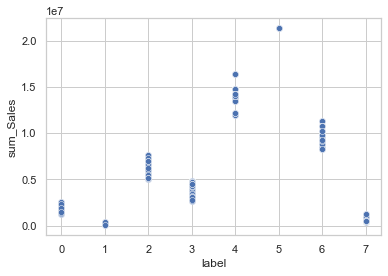

In [1085]:
# (v) hit-게임 분류하기( kmeans)

# (v) 매출 합계 컬럼 생성 
df['sum_Sales'] = df.NA_Sales + df.EU_Sales + df.JP_Sales + df.Other_Sales
df.head()


# data backup
df_org = df.copy()

#(v) 최근연도 df 추출
df_recent = df[df.Year >= max_year - (recent_year_boundary-1) ].copy()
len(df_recent)




#(v) 부트 스트랩 ( 10만개 )
df_boot = df_recent.sample(n=1000000, replace=True)
df_boot.head()
df_boot.info()


# 작업 df = 
df = df_boot







#(TODO) 히스토그램으로  갯수 vs 값 출력해 보기
#sns.histplot ( df.sum_Sales )

#(v) Kmeans 실행 하여 클러스터 나누기
# K-means 클러스터링 분석
kmeans = KMeans( random_state=42)

# (v) 부트스트랩을 한 data를 기준으로 클러스터링 진행
# (TODO) 혹시 셈플(원본) 데이터를 클러스터링 분류 기준으로 잡아야 하는가?
kmeans.fit_transform( np.array(df.sum_Sales.to_list()).reshape(-1, 1))    #(TODO) reshape(-1, 1) 해주어야 하는 이유 확인

# # 최근연도의_부트스트렙_ 셈플 데이터를 클러스터링 하기
# kmeans._transform(np.array(df_boot.sum_Sales.to_list()).reshape(-1, 1))
cluster_labels = kmeans.labels_

#(TODO)결과가 몇개의 클러스터 나뉘었는지 확인하는 간단한 방법이 뭐였더라?)
set_cluster = set(cluster_labels )
len(set_cluster)

#(v) 어느 클러스터가 최고 매출 클러스터인지 확인 
df['label'] = cluster_labels
df['label'] = df['label'].astype('category')

#(TODO) y값이 정상으로 출력되지 않는 이유는?
sns.scatterplot ( data = df , y= 'sum_Sales' , x = 'label' )

#[v] 어느 그룹까지를 hit-game으로 보면 좋을지 결정 하기
# (TODO) 어떤 방법으로 나누는 것이 좋을까? 

# K-Means
df_label_max = pd.DataFrame ()
for i in range (8) :
        df_insert = pd.DataFrame(
                        {
                                'label' : i ,
                                'max' : df[df.label == i ].sum_Sales.max() , 
                                'min' : df[df.label == i ].sum_Sales.min() , 
                                'count' : df[df.label == i ].count()
                        }
                        , index=[i]
                )
        #print(df_insert)
        df_label_max = df_label_max.append ( df_insert )

#(v) max() 값 순으로 정렬하여 출력하는 방법은?
df_label_max.sort_values(by='max' , axis=0, ascending=False, inplace=True)
df_label_max['cum_sum'] = df_label_max['count'].cumsum()
print(df_label_max)


# 상위 10% 값의 경우에는? 
upper = np.percentile(df.sum_Sales, 90) 
print ( f" 상위 10% =  {upper}  ")


# #(v) 프로그램적으로 최고값 클러스터를 찾아내는 방법은?
# cluster_hit_game = df_label_max.iloc[:2]['label']
# cluster_hit_game


In [1087]:
#(v) 프로그램적으로 최고값 클러스터를 찾아내는 방법은?
# hit game의 cluster 정하기
list_cluster_hit_game = df_label_max.iloc[:2]['label'].values.tolist()
print (list_cluster_hit_game)

[5, 4]



* (v)- 확률값 구하기



In [1088]:
#(v)- p ( hit 게임)
df_label_ratio = df['label'].value_counts(normalize=True ,dropna = True)
P_hit = df_label_ratio.sort_values( )[:2].sum()
display( P_hit )

# hit 게임
#df_hit = df[ ((df['label'] == 3 ) | ( df['label'] == 1 ))  ]
df_hit = df.query ( "label in @ list_cluster_hit_game "   )
#(TODO) in 으로 조회 하기
#df[ (df['label'] in list_cluster_hit_game) ]
#list_cluster_hit_game = 3, 1

# (v)- P ( 장르(각각) | hit 게임 )
col_name = 'Genre'
df_temp = df_hit[col_name].value_counts(normalize=True ) 
df_P_Genre_ratio_bar_hitGame = df_temp[df_temp > 0 ].to_frame("ratio")
display(df_P_Genre_ratio_bar_hitGame)

# (v)_ P ( 장르(각각) )
df_temp = df[col_name].value_counts(normalize=True ) 
df_P_Genre_ratio = df_temp[df_temp > 0 ].to_frame("ratio")
display(df_P_Genre_ratio)

# (v)- P ( 플랫폼(각각) | hit 게임 )
col_name = 'Platform'
df_temp = df_hit[col_name].value_counts(normalize=True ) 
df_P_Platform_ratio_bar_hitGame = df_temp[df_temp > 0 ].to_frame("ratio")
display(df_P_Platform_ratio_bar_hitGame)

# (v)- P ( 플랫폼(각각) )
df_temp = df[col_name].value_counts(normalize=True ) 
df_P_Platform_ratio = df_temp[df_temp > 0 ].to_frame("ratio")
display(df_P_Platform_ratio)

# (v)- P ( 지역(각각) | hit 게임 )
# (v)- P ( 지역(각각) )

    # # -> 아래 쪽에서 별도 구현


0.002258

,ratio
Shooter,0.552259
Action,0.337467
Racing,0.110275


,ratio
Action,0.311842
Role-Playing,0.117226
Adventure,0.099438
Sports,0.099329
Misc,0.093198
Shooter,0.081164
Racing,0.045812
Fighting,0.040367
Simulation,0.032765
Platform,0.030797


,ratio
X360,0.349424
PS3,0.333038
PS4,0.207263
3DS,0.110275


,ratio
PS3,0.181466
X360,0.129340
3DS,0.128600
PSV,0.105223
PC,0.095619
PS4,0.086780
PSP,0.080169
XOne,0.054889
Wii,0.051182
DS,0.048461


In [1089]:
df_P_Genre_ratio_bar_hitGame.loc['Shooter'] 
df_P_Genre_ratio.loc['Shooter']
df_P_Genre_ratio_bar_hitGame.loc['Shooter'] * P_hit / df_P_Genre_ratio.loc['Shooter']

ratio    0.015364
Name: Shooter, dtype: float64

In [1090]:
sri_ratio = (df_P_Genre_ratio_bar_hitGame.loc['Shooter'] * P_hit / df_P_Genre_ratio.loc['Shooter'])
print( sri_ratio.values[0] )

0.01536395446256961


#### 장르별 hit 게임 확률

,Genre,ratio
Shooter,Shooter,0.015364
Racing,Racing,0.005435
Action,Action,0.002444


<AxesSubplot:xlabel='Genre', ylabel='ratio'>

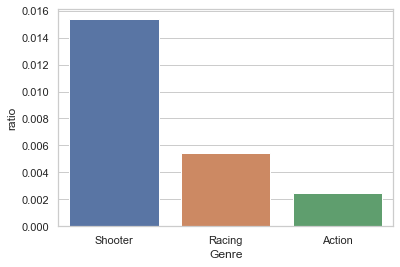

In [1091]:
# 장르별 hit 게임 확률 (베이지안)
# """        A : hit 게임
#             B : 장르(각)

#             P(A|B) = P(B|A) * P(A) / P(B)
# """

# hit 게임의 장르
#P_hitGame_bar_Genre =  df_P_Genre_ratio_bar_hitGame [] * P_hit / P_ge
list_Genre_hit = df_P_Genre_ratio_bar_hitGame.index 

# P (hit 게임 | 각 장르별 )
df_P_hitGame_bar_Genre = pd.DataFrame()
#df_P_hitGame_bar_Genre.columns = ['Genre','ratio']
#display ( df_P_hitGame_bar_Genre)

for genre in list_Genre_hit :
    sri_ratio = (df_P_Genre_ratio_bar_hitGame.loc[genre] * P_hit / df_P_Genre_ratio.loc[genre])
    #print ( f" ratio = { sri_ratio } : {df_P_Genre_ratio_bar_hitGame.loc[genre] } *  {P_hit}  / { df_P_Genre_ratio.loc[genre]} "      )
    df_insert = pd.DataFrame ({
        "Genre" : genre ,
        "ratio" :  sri_ratio.values[0] # 값만 
    }, index = [genre] )
    df_P_hitGame_bar_Genre = pd.concat( [df_P_hitGame_bar_Genre , df_insert] , axis= 0)

# 정렬
df_P_hitGame_bar_Genre = df_P_hitGame_bar_Genre.sort_values( by=['ratio'] , ascending= False )
display(df_P_hitGame_bar_Genre)


# # 시각화
sns.barplot ( data = df_P_hitGame_bar_Genre , x = 'Genre' , y = 'ratio' )
#(TODO) 퍼센트 값 추가



In [1092]:
df_P_hitGame_bar_Genre['ratio'].round(3)*100

Shooter    1.5
Racing     0.5
Action     0.2
Name: ratio, dtype: float64

#### 플렛폼 별 hit 게임 확률

,Platform,ratio
X360,X360,0.006100
PS4,PS4,0.005393
PS3,PS3,0.004144
3DS,3DS,0.001936


<AxesSubplot:xlabel='Platform', ylabel='ratio'>

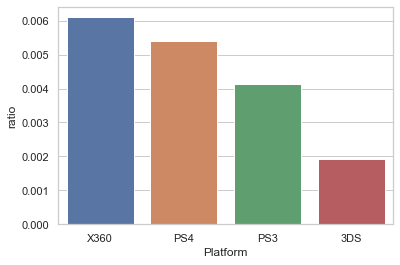

In [1093]:
""""
        목표 -> 각 플렛폼 별로 매출이 높을 확률  ? 베이지안
            A : hit 게임
            B : 플렛폼(각)

            P(A|B) = P(B|A) * P(A) / P(B)
"""

# hit 게임의 장르
#P_hitGame_bar_Genre =  df_P_Genre_ratio_bar_hitGame [] * P_hit / P_ge
list_Platform_hit = df_P_Platform_ratio_bar_hitGame.index 

# P (hit 게임 | 각 장르별 )
df_P_hitGame_bar_Platform = pd.DataFrame()
#df_P_hitGame_bar_Genre.columns = ['Genre','ratio']
#display ( df_P_hitGame_bar_Genre)

for platform in list_Platform_hit :
    sri_ratio = (df_P_Platform_ratio_bar_hitGame.loc[platform] * P_hit / df_P_Platform_ratio.loc[platform])
    #print ( f" ratio = { sri_ratio } : {df_P_Genre_ratio_bar_hitGame.loc[genre] } *  {P_hit}  / { df_P_Genre_ratio.loc[genre]} "      )
    df_insert = pd.DataFrame ({
        "Platform" : platform ,
        "ratio" :  sri_ratio.values[0] # 값만 
    }, index = [platform] )
    df_P_hitGame_bar_Platform = pd.concat( [df_P_hitGame_bar_Platform , df_insert] , axis= 0)

# 정렬
df_P_hitGame_bar_Platform = df_P_hitGame_bar_Platform.sort_values( by=['ratio'] , ascending= False )
display(df_P_hitGame_bar_Platform)


# # 시각화
sns.barplot ( data = df_P_hitGame_bar_Platform , x = 'Platform' , y = 'ratio' )
#(TODO) 퍼센트 값 추가




In [1094]:
df_P_hitGame_bar_Platform['ratio'].round(3)*100

X360    0.6
PS4     0.5
PS3     0.4
3DS     0.2
Name: ratio, dtype: float64

#### 지역별 hit 게임 확률
        목표 -> 각 플렛폼 별로 매출이 높을 확률  ? 베이지안
            A : hit 게임
            B : 지역 (각)

            P(A|B) = P(B|A) * P(A) / P(B)


In [1095]:
df_hit.head()

,Platform,Year,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Type,sum_Sales,label
10901,3DS,2011,Racing,4740000,3910000,2670000,890000,portable,12210000,4
3414,PS3,2013,Action,7010000,9270000,970000,4139999,console,21389999,5
10695,X360,2013,Action,9630000,5310000,60000,1380000,console,16380000,4
1973,PS4,2014,Action,3800000,5810000,360000,2020000,console,11990000,4
8892,PS4,2015,Shooter,5770000,5810000,350000,2310000,console,14240000,4


,Area,ratio
Other_Sales,Other_Sales,0.002686
EU_Sales,EU_Sales,0.002483
NA_Sales,NA_Sales,0.002390
JP_Sales,JP_Sales,0.000791


<AxesSubplot:xlabel='Area', ylabel='ratio'>

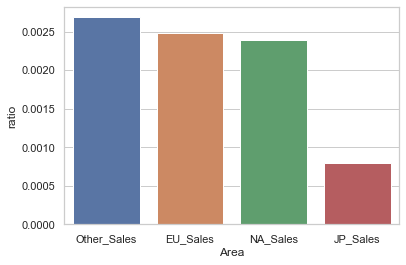

In [1096]:

# (v)- P ( 지역(각각) | hit 게임 ) 
#   => df_P_Area_bar_hitGame
#
df_melt_hit = pd.melt(df_hit, id_vars=['Platform', 'Year' , 'Genre' , 'Type' , 'sum_Sales' , 'label' ] , var_name='Area', value_name='area_Sales' )
df_melt_hit.head()

df_temp = df_melt_hit.groupby( by = 'Area' ).sum().drop( columns= [ 'Year' , 'sum_Sales' ])
sales_all = df_temp.sum() #.values[0]
df_temp = df_temp / sales_all
df_temp.columns = ['ratio']
df_temp = df_temp.sort_values( by=['ratio'] , ascending= False )

df_P_Area_bar_hitGame = df_temp.copy()


# (v)- P ( 지역(각각) ). 
#   => df_P_Area
df_melt = pd.melt(df, id_vars=['Platform', 'Year' , 'Genre' , 'Type' , 'sum_Sales' , 'label' ] , var_name='Area', value_name='area_Sales' )
df_melt.head()

df_temp = df_melt.groupby( by = 'Area' ).sum().drop( columns= [ 'Year' , 'sum_Sales' ])
sales_all = df_temp.sum() #.values[0]
df_temp = df_temp / sales_all
df_temp.columns = ['ratio']
df_temp = df_temp.sort_values( by=['ratio'] , ascending= False )

df_P_Area = df_temp.copy()




"""
        목표 -> 각 지역 별로 매출이 높을 확률  ? 베이지안
            A : hit 게임
            B : 지역 (각)

            P(A|B) = P(B|A) * P(A) / P(B)

"""

# hit 게임의 장르
#P_hitGame_bar_Genre =  df_P_Genre_ratio_bar_hitGame [] * P_hit / P_ge
list_Area = df_melt_hit.Area.unique().tolist()

# P (hit 게임 | 각 지역별 )
df_P_hitGame_bar_Area = pd.DataFrame()

for Area in list_Area :
    sri_ratio = (df_P_Area_bar_hitGame.loc[Area] * P_hit / df_P_Area.loc[Area])
    df_insert = pd.DataFrame ({
        "Area" : Area ,
        "ratio" :  sri_ratio.values[0] # 값만 
    }, index = [Area] )
    df_P_hitGame_bar_Area = pd.concat( [df_P_hitGame_bar_Area , df_insert] , axis= 0)

# 정렬
df_P_hitGame_bar_Area = df_P_hitGame_bar_Area.sort_values( by=['ratio'] , ascending= False )
display(df_P_hitGame_bar_Area)


# # 시각화
sns.barplot ( data = df_P_hitGame_bar_Area , x = 'Area' , y = 'ratio' )
#(TODO) 퍼센트 값 추가







In [426]:

# # (TODO) , na_action = None 이 왜 안먹힐까?
# df_hit.groupby( by= 'Platform' ,dropna = True, )['sum_Sales'].mean().map( lambda x : x , na_action = None ).dropna()

### 1.4 분석 결과

언어 = 영어! , 일본어! , 유럽 언어? => 프랑스? , 독일? ...
지역 = 미국 , 유럽 , 일본 , 기타 

장르별 힛트 게임 확률은  
Shooter         2.6
Platform        1.6
Simulation      0.8
Misc            0.6
Racing          0.6
Role-Playing    0.5
Action          0.2

플랫폼별 힛트 게임 확률은
X360    1.4
3DS     1.0
Wii     0.6
PS3     0.6
PS4     0.5

### 1.5 사용된 가정 정리
    * 받은 데이터는 전체 모든 게임의 데이터가 아닌 일부 셈플 데이터임 ( 2109년 스팀 출시 게임만 8396개 임 ) 
    * 외부 개발 의뢰가 아닌 자체 개발임
    * 개발 기간은 1년~2년 이라고 가정
    * 판매는 온라인 이지만, 마켓팅 비용은 지역 구분에 따라 추가 발생 함
    * 게임의 수익 비율은 장르별로 비슷하다고 가정
        장르별로 개발비용은 다르지만
        - 개발비용이 비싼 게임은 판매 가격도 비싸고, 개발 비용이 싼 게임은 판매 가격도 싸게 팔아서 수익율은 비슷 하다고 가정 한다.
    * 한 사람은 여러개의 게임을 구매 할 수 있다고 가정 -> 한개의 게임을 구매 후에도 다른 게임을 구매할 수 있음 ( 자금에 한도 없음 )
    * 매출 기본 단위는 , M ( 백만 , 10^6 )

### 1.6 분석시 발견된 문제점
GIGO
* 최근 데이터가 부족함 , 오래된 데이터에 비해서 너무 적음
* 데이터가 원 소스가 copy & paste로 만들어진 부분이 많은 것으로 보임 (dup), 
 - 이름만 다르고 매출 장르, 플랫폼 , 매출 data가 동일한 내용이 많음
* 데이터의 플랫폼이 편중되어 있는것으로 보임 , PC등의 data가 매우 부족

----
## 2. 필수 목표 ( 별도 요청 사항 )

### 필수 목표는 최근 데이터 뿐만이 아닌 전체 데이터에 대한 분석 내용이어서 year 범위를 조정한다.

### 2-1. 지역에 따라서 선호하는 게임 장르가 다를까 라는 질문에 대답을 하셔야합니다.

가설검증 
    : 지역별 선호 게임장르는 다른가?  
    
        -> 접근방법: 세부 가설검증으로 나눠서 분할 확인 후 결과를 합친다

        1.  전체중에서 선호 장르가 무엇인지 확인
            -> 결과 : 전체중 선호장르 = a

                * 부트 스트랩
                * 각 장르별 순위 집계
                * 모수 전체에 대한 선호 장르 확정 -> 오차율은? 의미가 있을까?

        2. 각 지역별로 가설검증

            ho = 전체의 최선호 장르
            h0 = a (a: 별도의 분석으로 구해진 값)
            h1 = A 지역의 최선호 장르

            귀무가설 : h1 = a
            대립가설 : h1 != a

        3. 2번 검증을 지역별로 모두 수행중에 하나라도 대립가설인 경우가 있으면 
            -> 지역별로 다름 
            anova를 이용해서 혹은 반복수행을 통해 검증한다.


결과 출력  

        -(DF) 지역 , 장르 , 장르별 매출 , 지역내 장르별 매출 비율
        -(그래프) 표 : x: 지역 , x_sub 장르 ( 누적 으로 표시 하자 , 너무 많다) , y: 지역내 장르별 매출 비율 

        X ->추가1) 시간대별로 지역의 선호도가 달라지지 않았는지 확인
            -(DF) 지역 , 연도 , 장르 , 장르별 매출 , 지역내 장르별 매출 비율
            -(그래프) 표 : x:연도 , x-sub 지역 , sub 장르 , y: 지역내 장르별 매출 비율 
                -> 너무 복잡하다 
                    -> 단순하게? 어떻게?

#### 상세 계획

셈플 →  여러개 5000 개의  셈플을 1000번 뽑은 것 → 정규분포를 따르고 , 모수의 평균에 수렴한다.  
    모수의 각 장르별 매출 비율 이 구해짐 

    a 장르의 매출 비율 평균  (정규 분포)  
    b 장르의 매출 비율 평균 (정규 분포)  
    …

    만약 a 장르의 평균 이  가장 높고 그 값을  Pa 라고 한다면   

[ 코드 :  
    1. 셈플을 5000개 뽑아서 각 장르별로 비율을 계산한다.  
    
    2. 위의 작업을 1000번 반복하여 결과를 list로 만든다. 
        ⇒ 각 장르별로 정규분포를 따르는 데이터를 얻게 되고   
        ⇒ 각 장르별 평균 비율 값을 얻게 된다.  
        
    3. 평균 비율 값이 가장 높은  장르와  비율의 평균 값을 얻는다.  
        fav_장르 ,  fav_장르_비율   
]  

셈플 → 지역 별로 나눔
    → 여러개 5000 개의  셈플을 1000번 뽑은 것 → 정규분포를 따르고 , 모수의 평균에 수렴한다.

    지역별로 각 장르별 매출 비율이 구해짐
    a 장르의 매출 비율 평균  (정규 분포) ( 특정 지역의 ) 
    의 값이 Pa라고 할 수 있는지를 가설검증 한다.

    -> 모든 지역에 대해서 가설검증을 진행한다.
    -> 하나라도 대립가설이 있으면 귀무가설 인정할 수 없음



In [1097]:
# (목표) 모집단의 최선호 장르,  매출 비율 하기
#  fav_장르  = ?
#  , fav_장르_매출비율 = ?
#  , lst_fav_장르_매출비율 = ?   ( t-test 메소드를 이용하기 위해서 필요함 )

"""
[ 코드 :
    1. 셈플을 5000개 뽑아서 각 장르별로 비율을 계산한다.
    2. 위의 작업을 1000번 반복하여 결과를 list로 만든다. 
        ⇒ 각 장르별로 정규분포를 따르는 데이터를 얻게 되고 
        ⇒ 각 장르별 평균 비율 값을 얻게 된다.
        
    3. 평균 비율 값이 가장 높은  장르와  비율의 평균 값을 얻는다.
        fav_장르 ,  fav_장르_비율 
]

"""

# 셈플 데이터
df_sample = df_target[['Genre' , 'NA_Sales' ,'EU_Sales' , 'JP_Sales' , 'Other_Sales'] ].copy()
df_sample['sum_Sales'] = df_sample.NA_Sales + df_sample.EU_Sales + df_sample.JP_Sales + df_sample.Other_Sales


# 파라미터로 전달할 셈플
df_tmp = df_sample[ ['Genre' , 'sum_Sales'] ].copy()


df_rslt_boot = pd.DataFrame() # 1000번의 추출 결과를 담을 df
for i in range( 1000) :

    #(v) 부트 스트랩 ( 5000개 )
    # 1. 셈플을 5000개 뽑아서 각 장르별로 비율을 계산한다.
    df_tmp_sample_boot_5000 = df_tmp.sample(n=5000, replace=True)

    # 전체 매출
    sum_Sales_all = df_tmp_sample_boot_5000['sum_Sales'].sum()  

    # 장르별 비율 계산
    df_Sales_Genre = df_tmp_sample_boot_5000.groupby ( by = 'Genre' ).sum()
    df_Sales_Genre =df_Sales_Genre.sort_values(by='sum_Sales' ,  ascending=False)
    df_Sales_Genre['ratio'] = df_Sales_Genre['sum_Sales'] /sum_Sales_all

    df_Sales_Genre.drop( columns=['sum_Sales'] ,inplace=True)


    # 결과 df에 이번 추출 결과를 담는다.
    df_rslt_boot = pd.concat( [df_rslt_boot, df_Sales_Genre.T] , axis= 0 )



In [1045]:
# 모수의 각 장르별 비율값을 구한다.
df_rslt_boot.reset_index( drop=True, inplace= True)
df_rslt_boot_01 = df_rslt_boot.mean().sort_values( ascending=False)

# 목표값 확인
fav_장르  = df_rslt_boot_01.index[0]
fav_장르_매출비율 = df_rslt_boot_01.loc[fav_장르]
lst_fav_장르_매출비율 = df_rslt_boot[fav_장르]


(fav_장르 , fav_장르_매출비율 , len(lst_fav_장르_매출비율))


('Action', 0.1958124353438505, 1000)

In [1057]:
# 지역 별   fav_장르 의 장르 비율 모수의 fav_장르_비율 과 같다고 할 수 있는지 검증


# 데이터
df_sample = df_target[['Genre' , 'NA_Sales' ,'EU_Sales' , 'JP_Sales' , 'Other_Sales'] ].copy()

df_rslt_boot = pd.DataFrame() # 1000번의 추출 결과를 담을 df
for i in range( 1000) :

    #(v) 부트 스트랩 ( 5000개 )
    # 1. 셈플을 5000개 뽑아서 각 장르별로 비율을 계산한다.
    df_tmp_sample_boot_5000 = df_sample.sample(n=5000, replace=True)

    #중간과정 df 생성
    df_tmp_melt = pd.melt(df_tmp_sample_boot_5000, id_vars=['Genre' ] , var_name='Area', value_name='Genre_Sales' )

    df_tmp = df_tmp_melt.groupby( by = [ 'Area' , 'Genre'] ).sum()
    df_sumSales_area = df_tmp_melt.groupby( by = [ 'Area' ] ).sum()

    # 목적 df 생성 
    ## 지역 매출 합계 컬럼 추가
    # (TODO) 복합 인덱스에서 인덱스 값을 별도로 추출하는 방법은?
    lst_Area_all = ['NA_Sales' ,'EU_Sales' , 'JP_Sales' , 'Other_Sales'] 
    lis_Genre_all = df['Genre'].unique()
    df_tmp_rslt = pd.DataFrame() # 목적값을 담을 df
    df_tmp_rslt = df_tmp.copy()
    df_tmp_rslt = df_tmp_rslt.reset_index() # index를 컬럼으로 변환

    # 지역별 매출 컬럼 추가 
    df_tmp_rslt['Area_Sales'] = df_tmp_rslt.Area.apply ( 
        lambda sel_Area : df_sumSales_area.loc[sel_Area]['Genre_Sales']
    )

    # 지역별 매출 비율 컬럼 추가 
    #(TODO) apply로는 왜 안될까
    # df_tmp_rslt['Area_Sales_ratio'] = df_tmp_rslt.Area.apply ( 
    #     lambda sel_Area : df_tmp_rslt['Genre_Sales'] / df_tmp_rslt['Genre_Sales']
    # )
    df_tmp_rslt['Area_Sales_ratio'] = df_tmp_rslt['Genre_Sales'] / df_tmp_rslt['Area_Sales']
    df_tmp_rslt = df_tmp_rslt[ df_tmp_rslt.Genre == fav_장르][['Area','Area_Sales_ratio']]
    df_tmp_rslt = df_tmp_rslt.set_index(['Area'] )

    # 결과 df에 이번 추출 결과를 담는다.
    df_rslt_boot = pd.concat( [df_rslt_boot, df_tmp_rslt.T] , axis= 0 )


df_rslt_boot.head()


Area,EU_Sales,JP_Sales,NA_Sales,Other_Sales
Area_Sales_ratio,0.230560,0.125706,0.212348,0.258390
Area_Sales_ratio,0.242595,0.133672,0.230997,0.280486
Area_Sales_ratio,0.260432,0.181641,0.239264,0.297716
Area_Sales_ratio,0.207839,0.147413,0.195249,0.205093
Area_Sales_ratio,0.196992,0.119185,0.199875,0.234576


In [1059]:
# 각 지역의  매출 비율이  , fav_장르_매출비율과 같다고 할 수 있는지 검증

# H0 (귀무가설): 전체 fav_장르의 매출 비율 == 각 지역의 매출 비율과 같다 
# H1 (대립가설): 전체 fav_장르의 매출 비율 != 각 지역의 매출 비율과 같다

for sel_Area in lst_Area_all :
    # T-Test 수행
    ans = t_test ( df_rslt_boot[sel_Area] , lst_fav_장르_매출비율 , "two-sided" )

    print ( f"{sel_Area} 의 pvalue = {ans}" )


대립가설이 맞음
NA_Sales 의 pvalue = 2.13845394216638e-06
대립가설이 맞음
EU_Sales 의 pvalue = 3.0851632844913363e-126
(todo) 에러 발생
JP_Sales 의 pvalue = nan
(todo) 에러 발생
Other_Sales 의 pvalue = nan


In [1060]:
# 가설검증 결과 = 지역 마다 선호 장르가 다르다 


### 2-2. 연도별 게임의 트렌드가 있을까 라는 질문에 대답을 하셔야합니다.
### 2-2-1 트렌드 => 최 선호 장르

가설검증 
    : 연도별 트렌드가 있다?

        트렌드란? 무엇 ? 
            : 트렌드 -> 배운것을 이용해서 수치로 나타낼 수 있을까?
                경향?
            
            * (TODO) 사람이 인식하지 못하고 있는 요소를.... 머신러닝을 이용해서 어떤 트렌드가 있다는 걸 찾아낼 수 있을까? 

        2-1 형식의 가설 검증 방법은 오히려 적당하지 않아 보임 
            (가설검증 방법 폐기)

        그래프로 직관적으로 찾아내는것이 좋지 않을까?

그래프 :

        -(DF) 연도, 장르 , 장르별 매출 , 장르별 매출 비율 
        -(그래프) (bar) x: 연도 , sub 장르 , y: 장르별 매출 비율

        -(그래프) (꺽은선) x: 연도 , y: 매출비율 , hue : 장르
            + (bar) x : 연도 , y : 전체매출  

In [1199]:
# 연도 list 생성
lst_Year = np.sort( df_target.Year.unique())
lst_Year


array([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2020])

In [1200]:
# 장르 list 
list_Genre= df_target.Genre.unique().to_list()
list_Genre

['Action',
 'Adventure',
 'Misc',
 'Platform',
 'Sports',
 'Simulation',
 'Racing',
 'Role-Playing',
 'Puzzle',
 'Strategy',
 'Fighting',
 'Shooter']

In [ ]:
#(TODO) 연도별 장르별 매출 평균을 구하기 위해서는 해당 연도의 data만 뽑아서 부트 스트래핑 하는게 올바른가?
# 아니면 전체를 부트스트래핑 하고 거기에서 해당 연도만 뽑는것이 올바른가?

In [ ]:
#(TODO)scipy 모듈이 업그레이드가 필요한지 여부는 어떻게 확인해야 하나?
#업그레이드 중 왜 에러가 나는가?( No module named 'mesonpy' )
# !pip install scipy --upgrade

In [1286]:
# 부트스트래핑을 통하여 모수의 장르별 데이터 평균 매출비율 추정 

# 데이터
df_sample = df_target[ ['Year' , 'Platform' , 'Genre' , 'Type' , 'sum_Sales'] ].copy()


#sel_year = 1980


def 해당연도의장르별매출비율조회(df_sample ,  sel_year  ) :
    df_rslt_boot = pd.DataFrame() # 1000번의 추출 결과를 담을 df
    for i in range( 1000 ) :

        #(v) 부트 스트랩 ( 5000개 )
        # 1. 셈플을 5000개 뽑는다
        df_tmp_sample_boot_5000 = df_sample.sample(n=5000, replace=True)

        #중간과정 df 생성
        df_tmp = df_tmp_sample_boot_5000.groupby( by = [ 'Year' , 'Genre'] ).sum().reset_index()
        df_tmp_01 = df_tmp.loc[df_tmp['Year'] ==sel_year].copy() # warnging 삭제용 copy()
        sum_all_sales =  df_tmp_01['sum_Sales'].sum()

        # 매출 비율
        df_tmp_01['ratio'] = df_tmp_01['sum_Sales'] / sum_all_sales
        df_tmp_01['all_Sales'] = sum_all_sales

        df_tmp_rslt = pd.DataFrame(
            [df_tmp_01['ratio'].T]
            , index=[sel_year]
            # (TODO) DataFrame 생성시 직접 columns를 지정하면 에러가 나는 이유는?
            #, columns = df_tmp_01['Genre']
        )
        df_tmp_rslt.columns = df_tmp_01['Genre']
        
        df_tmp_rslt['all_Sales'] = sum_all_sales

        #결과 df에 이번 추출 결과를 담는다
        df_rslt_boot = pd.concat( [df_rslt_boot, df_tmp_rslt] , axis= 0 )


    df_rslt_boot = df_rslt_boot.reset_index()
    df_rslt_boot.rename(columns = {'index':'year'},inplace=True)
    df_rslt_boot = df_rslt_boot.groupby( by ='year').mean()

    return df_rslt_boot


# sel_year= 1980
# sri_Sales_ratio_year = 해당연도의장르별매출비율조회(df_sample ,  sel_year  ) 
# sri_Sales_ratio_year
df_Genre_ratio_year = pd.DataFrame()
for sel_year in  lst_Year :

    sri_Sales_ratio_year = 해당연도의장르별매출비율조회(df_sample ,  sel_year  ) 


     #결과 df에 이번 추출 결과를 담는다
    df_Genre_ratio_year = pd.concat( [df_Genre_ratio_year, sri_Sales_ratio_year] , axis= 0 )


In [1292]:
df_Genre_ratio_year.head()

Genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy,all_Sales
year,,,,,,,,,,,,,
1980,0.081926,0.000000,0.124683,0.384531,0.000000,0.000000,0.000000,0.0,0.408860,0.000000,0.000000,0.0,3421590.0
1981,0.438745,0.000000,0.000000,0.000000,0.162378,0.061485,0.015878,0.0,0.283468,0.014686,0.023360,0.0,10970780.0
1982,0.272771,0.000000,0.000000,0.033443,0.195621,0.245865,0.057140,0.0,0.150741,0.000000,0.044420,0.0,8927160.0
1983,0.228194,0.039326,0.000000,0.106950,0.397054,0.052988,0.000000,0.0,0.034748,0.000000,0.140739,0.0,5121230.0
1984,0.059198,0.000000,0.000000,0.062537,0.033607,0.138957,0.200969,0.0,0.334571,0.000000,0.170162,0.0,15909040.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


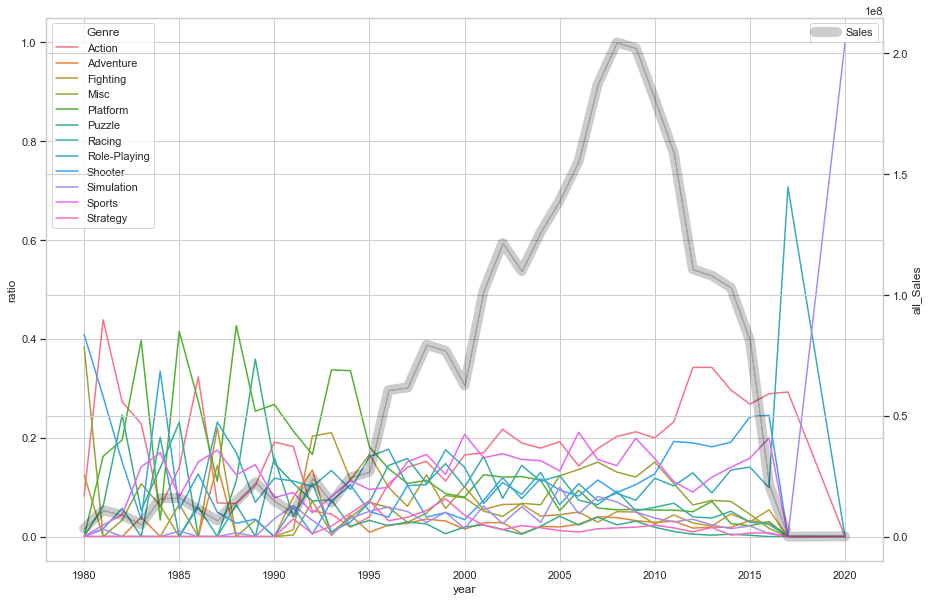

In [1327]:
# 시각화용 df 
df_Genre_ratio_year_resetIndex = df_Genre_ratio_year.reset_index()

#컬럼명 변경
df_Genre_ratio_year_resetIndex.rename(columns = {'index':'year'},inplace=True)

df_Genre_ratio_year_melt = pd.melt(df_Genre_ratio_year_resetIndex, id_vars=['year' ,'all_Sales'] , var_name='Genre', value_name='ratio' )

# df_Genre_ratio_year_melt.head()
# 시각화
fig= plt.figure( figsize = (15,10) )
ax = fig.add_subplot (1,1,1)
sns.lineplot( data= df_Genre_ratio_year_melt , x= 'year' , y = 'ratio' , hue='Genre' ,ax=ax)


ax2 = ax.twinx() # twinx함수의 도움으로 두 개의 다른 axes객체를 사용하여 두 개의 다른 Y축으로 플롯을 만들 수 있다.
ax2.legend(loc = 'upper right')
sns.lineplot ( data=df_Genre_ratio_year_melt ,x='year', y='all_Sales' , ax =ax2 , label = 'Sales', color='black', alpha=0.2, linewidth=10)
# sns.lineplot( x=df_Genre_ratio_year_melt['index'] , y=df_Genre_ratio_year_melt['ratio'] , hue=['Genre']  )
plt.show()

매출이 충분히 있는 1995~2015년 만을 본다면.  
    * Action , Sports 가 상위를 차지하고 있고.  
    * Shooter 장르가 상위권 이면서 조금씩 매출 비율이 늘어나는 경향이 있다고 할 수 있을 것으로 보인다. 




### 2-2-2 트렌드 => 최 선호 플렛폼


In [1221]:
# 방법은 위와 동일하나 원본 데이터가 플렛폼 편중 되어 있어서 분석에 의미가 없음
# 시기별로 특정 플랫폼이 떳다가 사라지는 현상이 반복됨 

In [1330]:
# 부트스트래핑을 통하여 모수의 장르별 데이터 평균 매출비율 추정 

# 데이터
df_sample = df_target[ ['Year' , 'Platform' , 'Genre' , 'Type' , 'sum_Sales'] ].copy()


#sel_year = 1980


def 해당연도의장르별매출비율조회(df_sample ,  sel_year  ) :
    df_rslt_boot = pd.DataFrame() # 1000번의 추출 결과를 담을 df
    for i in range( 1000 ) :

        #(v) 부트 스트랩 ( 5000개 )
        # 1. 셈플을 5000개 뽑는다
        df_tmp_sample_boot_5000 = df_sample.sample(n=5000, replace=True)

        #중간과정 df 생성
        df_tmp = df_tmp_sample_boot_5000.groupby( by = [ 'Year' , 'Platform'] ).sum().reset_index()
        df_tmp_01 = df_tmp.loc[df_tmp['Year'] ==sel_year].copy() # warnging 삭제용 copy()
        sum_all_sales =  df_tmp_01['sum_Sales'].sum()

        # 매출 비율
        df_tmp_01['ratio'] = df_tmp_01['sum_Sales'] / sum_all_sales
        df_tmp_01['all_Sales'] = sum_all_sales

        df_tmp_rslt = pd.DataFrame(
            [df_tmp_01['ratio'].T]
            , index=[sel_year]
            # (TODO) DataFrame 생성시 직접 columns를 지정하면 에러가 나는 이유는?
            #, columns = df_tmp_01['Genre']
        )
        df_tmp_rslt.columns = df_tmp_01['Platform']
        
        df_tmp_rslt['all_Sales'] = sum_all_sales

        #결과 df에 이번 추출 결과를 담는다
        df_rslt_boot = pd.concat( [df_rslt_boot, df_tmp_rslt] , axis= 0 )


    df_rslt_boot = df_rslt_boot.reset_index()
    df_rslt_boot.rename(columns = {'index':'year'},inplace=True)
    df_rslt_boot = df_rslt_boot.groupby( by ='year').mean()

    return df_rslt_boot


# sel_year= 1980
# sri_Sales_ratio_year = 해당연도의장르별매출비율조회(df_sample ,  sel_year  ) 
# sri_Sales_ratio_year
df_Genre_ratio_year = pd.DataFrame()
for sel_year in  lst_Year :

    sri_Sales_ratio_year = 해당연도의장르별매출비율조회(df_sample ,  sel_year  ) 


     #결과 df에 이번 추출 결과를 담는다
    df_Genre_ratio_year = pd.concat( [df_Genre_ratio_year, sri_Sales_ratio_year] , axis= 0 )


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


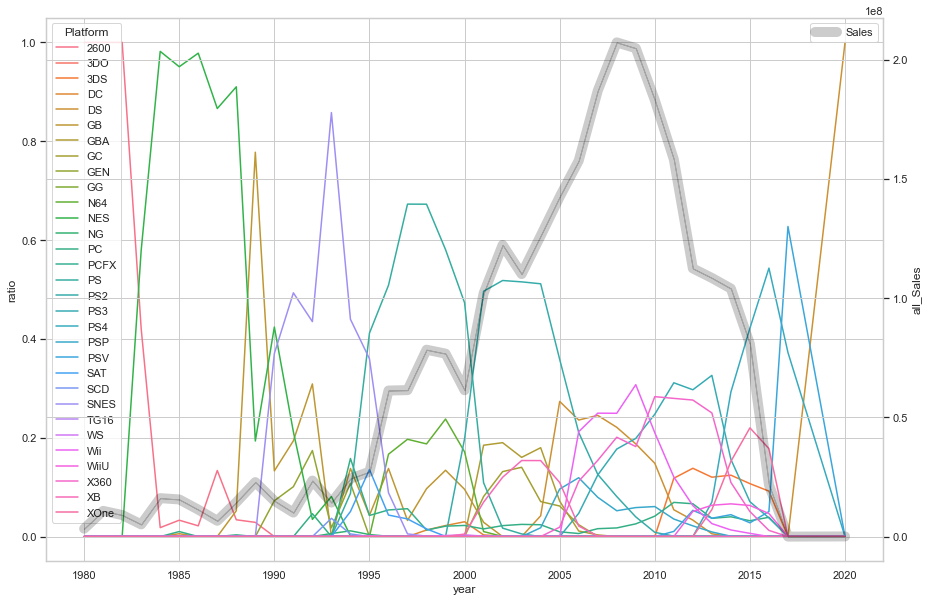

In [1331]:
# 시각화용 df 
df_Genre_ratio_year_resetIndex = df_Genre_ratio_year.reset_index()

#컬럼명 변경
df_Genre_ratio_year_resetIndex.rename(columns = {'index':'year'},inplace=True)

df_Genre_ratio_year_melt = pd.melt(df_Genre_ratio_year_resetIndex, id_vars=['year' ,'all_Sales'] , var_name='Platform', value_name='ratio' )

# df_Genre_ratio_year_melt.head()
# 시각화
fig= plt.figure( figsize = (15,10) )
ax = fig.add_subplot (1,1,1)
sns.lineplot( data= df_Genre_ratio_year_melt , x= 'year' , y = 'ratio' , hue='Platform' ,ax=ax)


ax2 = ax.twinx() # twinx함수의 도움으로 두 개의 다른 axes객체를 사용하여 두 개의 다른 Y축으로 플롯을 만들 수 있다.
ax2.legend(loc = 'upper right')
sns.lineplot ( data=df_Genre_ratio_year_melt ,x='year', y='all_Sales' , ax =ax2 , label = 'Sales', color='black', alpha=0.2, linewidth=10)
# sns.lineplot( x=df_Genre_ratio_year_melt['index'] , y=df_Genre_ratio_year_melt['ratio'] , hue=['Genre']  )
plt.show()

### 2-3. 출고량이 높은 게임에 대한 분석 및 시각화 프로세스가 포함되어야 합니다.
    *(v) hit game 의 전체 매출 비중
    *(v) 연도별 hit game의 전체 매출 비중 변화
    *(v) hit game 의 장르별 비율
    *(v) hit game 의 플렛폼별 비율  


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 11707 to 12469
Data columns (total 11 columns):
 #   Column       Non-Null Count    Dtype   
---  ------       --------------    -----   
 0   Platform     1000000 non-null  category
 1   Year         1000000 non-null  int64   
 2   Genre        1000000 non-null  category
 3   NA_Sales     1000000 non-null  int64   
 4   EU_Sales     1000000 non-null  int64   
 5   JP_Sales     1000000 non-null  int64   
 6   Other_Sales  1000000 non-null  int64   
 7   Type         1000000 non-null  category
 8   sum_Sales    1000000 non-null  int64   
 9   label        1000000 non-null  category
 10  hit          1000000 non-null  object  
dtypes: category(4), int64(6), object(1)
memory usage: 64.9+ MB
   label       max       min   count  cum_sum
4      4  82740000  82740000      71       71
3      3  40240000  28310000     554      625
5      5  24750000  17280000     823     1448
1      1  16380000   8840000    3242     4690
6     

0.00469

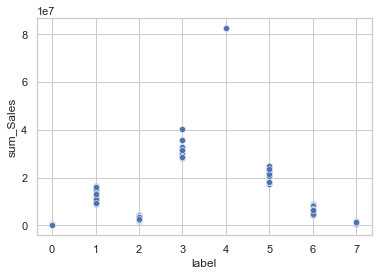

In [1064]:
df = df_target

#(v) 부트 스트랩 ( 10만개 )
df_boot = df.sample(n=1000000, replace=True)
df_boot.reset_index ( drop= True)
df_boot.head()
df_boot.info()

# 작업 df = 부트스트래핑 한 데이터 기준
df = df_boot


#(v) Kmeans 실행 하여 클러스터 나누기
# K-means 클러스터링 분석
kmeans = KMeans( random_state=42)

# (v) 부트스트랩을 한 data를 기준으로 클러스터링 진행
# (TODO) 혹시 셈플(원본) 데이터를 클러스터링 분류 기준으로 잡아야 하는가?
kmeans.fit_transform( np.array(df.sum_Sales.to_list()).reshape(-1, 1))    #(TODO) reshape(-1, 1) 해주어야 하는 이유 확인

# # 최근연도의_부트스트렙_ 셈플 데이터를 클러스터링 하기
# kmeans._transform(np.array(df_boot.sum_Sales.to_list()).reshape(-1, 1))
cluster_labels = kmeans.labels_

#(TODO)결과가 몇개의 클러스터 나뉘었는지 확인하는 간단한 방법이 뭐였더라?)
set_cluster = set(cluster_labels )
len(set_cluster)

#(v) 어느 클러스터가 최고 매출 클러스터인지 확인 
df['label'] = cluster_labels
df['label'] = df['label'].astype('category')

#(TODO) y값이 정상으로 출력되지 않는 이유는?
sns.scatterplot ( data = df , y= 'sum_Sales' , x = 'label' )

#[v] 어느 그룹까지를 hit-game으로 보면 좋을지 결정 하기
# (TODO) 어떤 방법으로 나누는 것이 좋을까? 

# K-Means
df_label_max = pd.DataFrame ()
for i in range (len(set_cluster)) :
        df_insert = pd.DataFrame(
                        {
                                'label' : i ,
                                'max' : df[df.label == i ].sum_Sales.max() , 
                                'min' : df[df.label == i ].sum_Sales.min() , 
                                'count' : len(df[df.label == i ])
                        }
                        , index=[i]
                )
        #print(df_insert)
        df_label_max = pd.concat( [df_label_max , df_insert] , axis= 0)
        

#(v) max() 값 순으로 정렬하여 출력하는 방법은?
df_label_max.sort_values(by='max' , axis=0, ascending=False, inplace=True)
df_label_max['cum_sum'] = df_label_max['count'].cumsum()
print(df_label_max)


# 상위 10% 값의 경우에는? 
upper = np.percentile(df.sum_Sales, 90) 
print ( f" 상위 10% =  {upper}  ")

# hit game의 cluster 정하기
list_cluster_hit_game = df_label_max.iloc[:4]['label'].values.tolist()
print (list_cluster_hit_game)

#(v)- p ( hit 게임)
df_label_ratio = df['label'].value_counts(normalize=True ,dropna = True)
P_hit = df_label_ratio.sort_values( )[:4].sum()
display( P_hit )

# hit 게임
df_hit = df.query ( "label in @ list_cluster_hit_game "   )
df_hit.reset_index ( drop=True)
#(TODO)
#df_hit = df.loc[ (df.label in [2, 4]).any() ] 
#df_hit = df[ ((df['label'] == 3 ) | ( df['label'] == 1 ))  ]

df_hit.head()

# hit 컬럼에 hit game 여부 표시 하기
df['hit'] = df.label.apply ( lambda x : True if x in list_cluster_hit_game else False   )  

df = df.reset_index( drop = True)

#  hit game의 전체판매량 / 전체 판매량 = 15.0 %


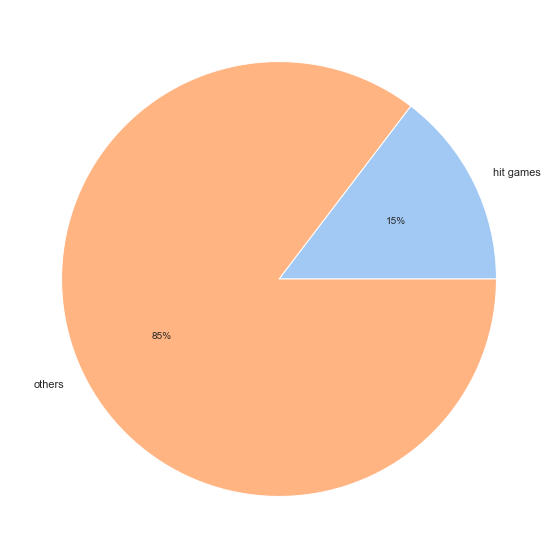

In [1065]:
# hit game 의 전체 매출 비중
all_sales_df_boot = df.sum_Sales.sum()
all_sales_df_hit =  df_hit.sum_Sales.sum()

print ( f"#  hit game의 전체판매량 / 전체 판매량 = { np.round((all_sales_df_hit / all_sales_df_boot),2) * 100 } %")


# 시각화 
lst_tmp = [ all_sales_df_hit , ( all_sales_df_boot - all_sales_df_hit )]
keys = [ 'hit games' , 'others']

# plotting data on chart
plt.figure( figsize = (10,10) )
plt.pie ( x=lst_tmp , labels=keys, autopct='%.0f%%' , colors=colors)
plt.show()
  


<AxesSubplot:xlabel='Year', ylabel='sum_Sales'>

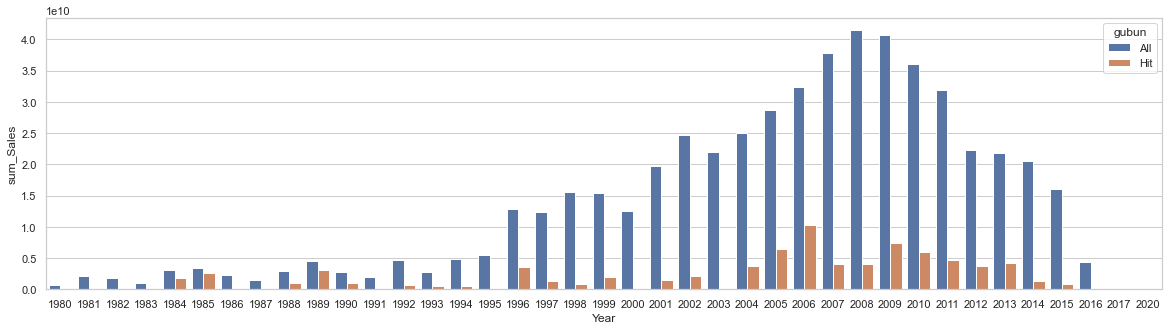

In [1066]:
#(v) 연도별 hit game의 전체 매출 비중 변화

# 연도별 게임 매출
df_temp_01 = df.groupby ( by = ['Year' ] ).sum()
df_temp_01.head()

# 연도별 히트게임 매출
df_temp_02 = df_hit.groupby ( by = ['Year' ] ).sum()
df_temp_02.head()

# 매출 정보 합치기
df_temp = pd.merge( left = df_temp_01 , right = df_temp_02 , how='left' , left_index = True, right_index = True)
df_temp = df_temp.fillna(0)

# df 형태 다듬기 ( 시각화 위해 )
df_temp = df_temp[ ['sum_Sales_x' , 'sum_Sales_y'] ]
df_temp.columns = [ 'All', 'Hit' ]
df_temp['Hit'] = df_temp['Hit'].astype('int')
df_temp['Hit_ratio'] = (df_temp['Hit'] / df_temp['All']).round(2)

df_temp['Year']= df_temp.index
df_melt = pd.melt(df_temp, id_vars=['Hit_ratio' ,'Year' ] , var_name='gubun' , value_name='sum_Sales' )
df_melt

# 시각화
plt.figure( figsize = (20,5) )
sns.barplot ( data = df_melt , y = 'sum_Sales' , x = 'Year' , hue = 'gubun')


# => 셈플 데이터가 안 좋아서
#   -> 최근 데이터가 너무 없음 
# (TODO) 이대로 데이터를 쓰는게 맞는가?
# (TODO) 판단 기준은?


In [1067]:
sum_Sales_all = df_hit.sum_Sales.sum() 
sum_Sales_all

79085509613

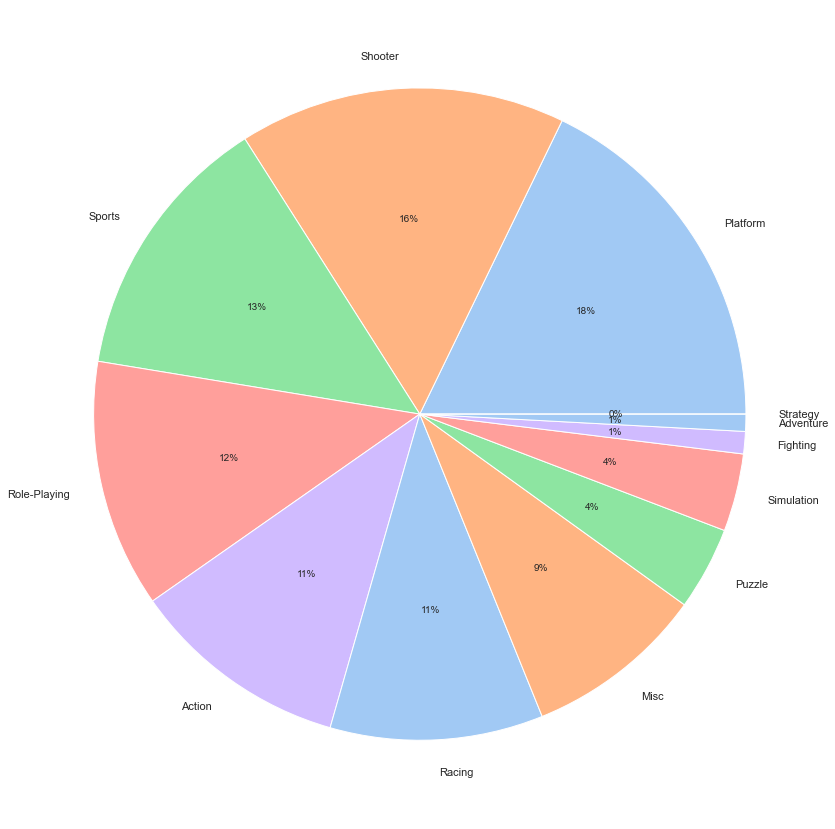

In [1068]:
#*(v) hit game 의 장르별 비율
df_tmp = df_hit.groupby (  by = 'Genre' )['sum_Sales'].sum()
df_tmp = df_tmp.sort_values( ascending=False)

# # 시각화 
plt.figure( figsize = (15,15) )
plt.pie ( x= df_tmp , labels=df_tmp.index, autopct='%.0f%%' , colors=colors)
plt.show()
  

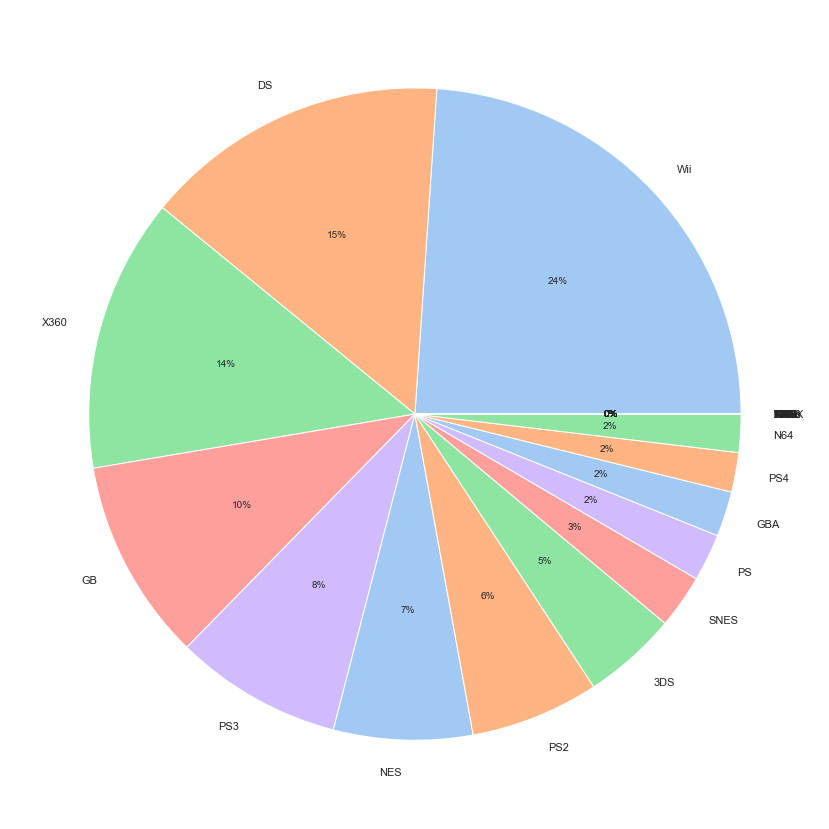

In [1069]:
#(v) hit game 의 플렛폼별 비율

df_tmp = df_hit.groupby (  by = 'Platform' )['sum_Sales'].sum()
df_tmp = df_tmp.sort_values( ascending=False)

# # 시각화 
plt.figure( figsize = (15,15) )
plt.pie ( x= df_tmp , labels=df_tmp.index, autopct='%.0f%%' , colors=colors)
plt.show()

## 3. 기타 사항 ( 추가 적인 참고 사항 , 분석 도중 추가 도출 된 사항)
